## Preparação dos dados

In [46]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import stft

data1 = np.load('datasets/Gabi.npy')
data2 = np.load('datasets/Jesse.npy')

data1.shape, data2.shape

((28, 1000, 4), (28, 1000, 4))

In [47]:
# Correção do número de eletrodos e unificação

# Como dito anteriormente, os dois primeiros eletrodos são funcionais
data1 = data1[:,:,:2]
data2 = data2[:,:,:2]

print(data1.shape, data2.shape)

data = np.array([data1, data2])
print(data.shape)

# Colocando os dados na dimensão final
data = data.transpose(0, 1, 3, 2)
print(data.shape)

(28, 1000, 2) (28, 1000, 2)
(2, 28, 1000, 2)
(2, 28, 2, 1000)


In [48]:
# Funções para aplicação dos filtros temporais
%matplotlib inline
from scipy import signal

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

In [49]:
# Aplicação dos filtros
filtered_data = butter_notch(data, 60)
filtered_data = butter_bandpass(filtered_data, 5, 50)
filtered_data.shape

(2, 28, 2, 1000)

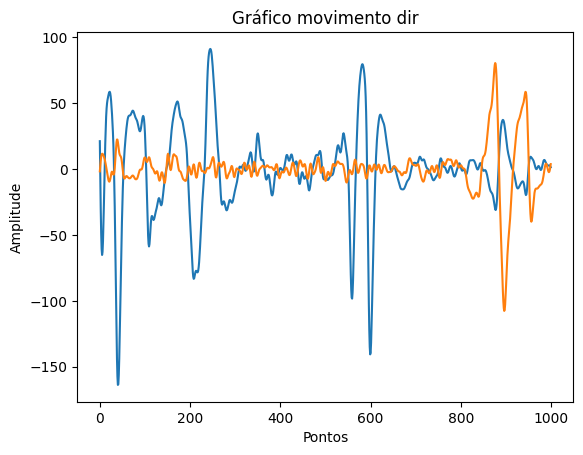

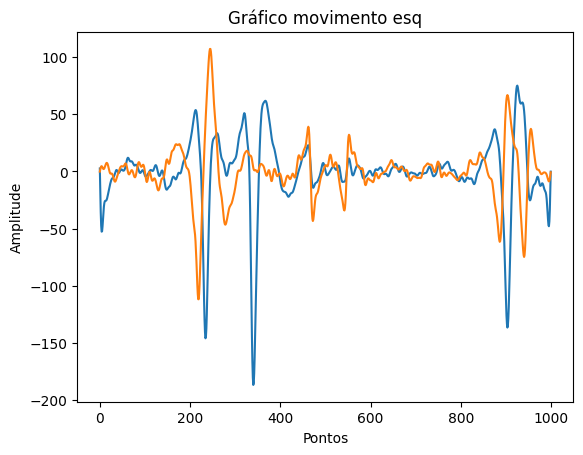

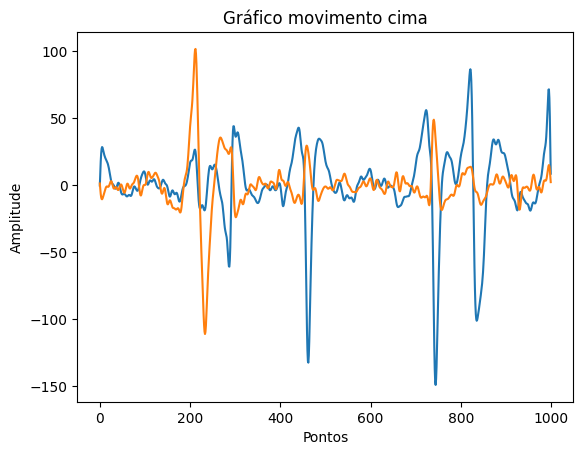

In [50]:
# Visualização de 3 das 28 classes
labels_str = ['dir', 'esq', 'cima', 'baixo', 'cima', 'baixo',
              'baixo', 'esq', 'dir', 'baixo', 'dir', 'dir', 'esq', 'cima',
              'baixo', 'cima', 'esq', 'dir', 'cima', 'esq', 'baixo', 'esq',
              'dir', 'esq', 'cima', 'dir', 'cima', 'baixo']

for target in range(0, 3):
    plt.plot(filtered_data[0, target, 0, :])
    plt.plot(filtered_data[0, target, 1, :])
    plt.xlabel('Pontos')
    plt.ylabel('Amplitude')
    plt.title(f"Gráfico movimento {labels_str[target]}")
    plt.show()

In [51]:
# Corte dos dados
data = filtered_data[:, :, :, 150:800] 

In [52]:
segment = 64
nperseg_freq = 64
print('', data.shape)

overlap_time = 0  # Iniciando com sobreposição zero no domínio do tempo
overlap_freq = nperseg_freq // 2  # Sobreposição de 50% no domínio da frequência

while True:
    # Cálculo de n_win e criação de ids
    n_win = int((data.shape[-1] - segment) / (overlap_time + 1)) + 1
    ids = np.arange(n_win) * (overlap_time + 1)

    # Janelas no domínio do tempo
    chunks_time = [data[:, :, :, k:(k + segment)] for k in ids]
    chunks_time = np.array(chunks_time).transpose(1, 2, 3, 0, 4)

    # Janelas no domínio da frequência
    _, _, chunks_freq = stft(data, fs=200, nperseg=nperseg_freq, noverlap=overlap_freq)
    chunks_freq = chunks_freq.transpose(0, 1, 2, 4, 3)

    # Verificando se o número de janelas é o mesmo
    if chunks_time.shape[3] == chunks_freq.shape[3]:
        break  # Se o número de janelas for igual, saia do loop
    else:
        overlap_time += 1  # Incrementa a sobreposição no domínio do tempo para tentar igualar o número de janelas

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')

 (2, 28, 2, 650)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (2, 28, 2, 22, 64) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (2, 28, 2, 22, 33) - (classes+ensaios, canais, janelas, linhas)


In [53]:
# Separar os participantes e salvar
print(chunks_freq[0].shape, chunks_freq[1].shape)
print(chunks_time[0].shape, chunks_time[1].shape)

p1_freq = chunks_freq[0]
p1_time = chunks_time[0]

p2_freq = chunks_freq[1]
p2_time = chunks_time[1]

np.save("datasets/p1_freq", p1_freq)
np.save("datasets/p1_time", p1_time)

np.save("datasets/p2_freq", p2_freq)
np.save("datasets/p2_time", p2_time)

(28, 2, 22, 33) (28, 2, 22, 33)
(28, 2, 22, 64) (28, 2, 22, 64)
